In [304]:
import pandas as pd
from matplotlib import pyplot
import seaborn as sns; sns.set_theme()
import os
import glob

def get_files(fn):
    home = os.path.expanduser('~')
    path = f'{home}/Downloads/project_mining_2022/dataset/'
    files = glob.glob(path + fn + '/*.csv')
    return files


def to_date(char):
    return char[:4] + '-' + char[4:6] + '-' + char[6:8]

# for each file create a pandas df
# concatenate them all together
# change index to datetime
def parse_file(files, filenames):
    list_of_pandas = []
    for i, f in enumerate(files):
        # if file empty
        if os.stat(f).st_size != 0:
            # create df
            temp = pd.read_csv(f, header=0, nrows=288, skip_blank_lines=False)
            # create date column
            temp['Date'] = [to_date(filenames[i]) for _ in range(288)]
            # append df 
            list_of_pandas += [temp]
    # cast all together
    df = pd.concat(list_of_pandas, ignore_index=True)
    df.index = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y-%m-%d %H:%M:%S')
    df.drop(columns=['Date', 'Time'], inplace=True)
    return df

In [305]:
# list files
demand_files = get_files('demand')
source_files = get_files('sources')

# list filenames to use on timestamps
filenames = [file[-12: -4] for file in demand_files]

# get data from files
demands = parse_file(demand_files, filenames)
sources = parse_file(source_files, filenames)

# move values and drop temp cols
sources['Natural gas'].fillna(sources['Natural Gas'], inplace=True)
sources['Large hydro'].fillna(sources['Large Hydro'], inplace=True)
sources.drop(columns=['Natural Gas', 'Large Hydro'], inplace=True)

In [306]:
demands.shape

(315648, 3)

In [307]:
# null values in demands are probably due to power cut
# so, linear interpolation will be good estimate
demands.interpolate(method='linear', axis=0, inplace=True)

In [308]:
demands.isna().sum()
demands.loc[demands['Current demand'] <= 0]

,Day ahead forecast,Hour ahead forecast,Current demand
2019-10-02 14:45:00,24209.0,24727.0,-2651.0
2019-10-02 14:50:00,24209.0,24993.0,-2646.0


In [309]:
sources.isna().sum()

Solar           54
Wind            54
Geothermal     342
Biomass         54
Biogas          54
Small hydro     54
Coal            54
Nuclear         54
Natural gas    342
Large hydro     54
Batteries       54
Imports        342
Other           54
dtype: int64

In [310]:
sources.interpolate(method='linear', axis=0, inplace=True)

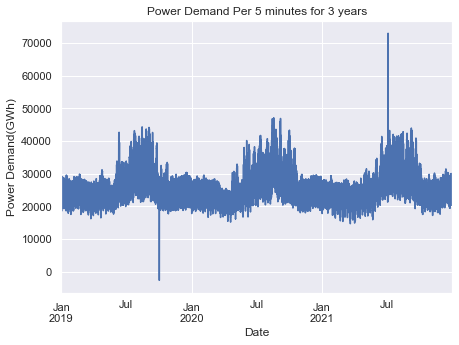

In [311]:
pyplot.rcParams['figure.figsize'] = [7, 5]
demands['Current demand'].plot(xlabel='Date', ylabel='Power Demand(GWh)', title = 'Power Demand Per 5 minutes for 3 years')
pyplot.show()

In [312]:
# Rolling mean and std for demand with a window of a day
demands_rolmean = demands['Current demand'].rolling(window=289).mean()
demands_rolstd = demands['Current demand'].rolling(window=289).std()

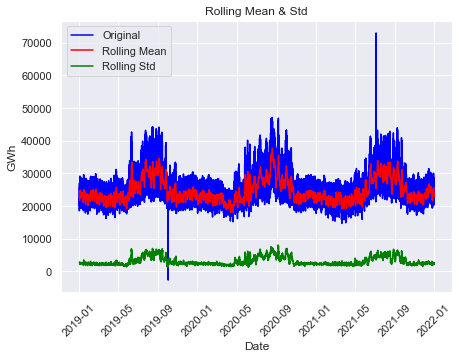

In [313]:
pyplot.title('Rolling Mean & Std')
pyplot.xlabel('Date')
pyplot.ylabel('GWh')
pyplot.plot(demands['Current demand'], color='blue', label='Original')
pyplot.plot(demands_rolmean, color='red', label='Rolling Mean')
pyplot.plot(demands_rolstd, color='green', label='Rolling Std')
pyplot.legend(loc='best')
pyplot.xticks(rotation=45)
pyplot.show()

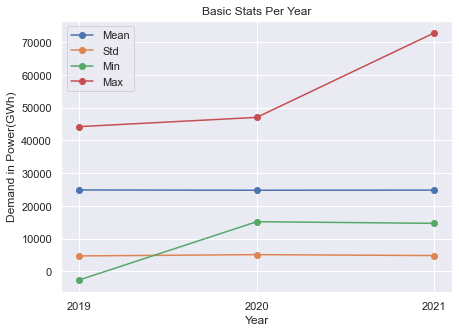

In [314]:
# calc mean, std, min, max per year
means = demands.groupby(by=demands.index.year).mean()['Current demand']
stds = demands.groupby(by=demands.index.year).std()['Current demand']
mins = demands.groupby(by=demands.index.year).min()['Current demand']
maxs = demands.groupby(by=demands.index.year).max()['Current demand']

basic_stats_year = pd.concat([means, stds, mins, maxs], axis=1, keys=['Mean', 'Std', 'Min', 'Max'])
basic_stats_year.plot(xlabel='Year', ylabel='Demand in Power(GWh)', title='Basic Stats Per Year', marker='o')
pyplot.xticks(demands.index.year.unique().values)
pyplot.show()

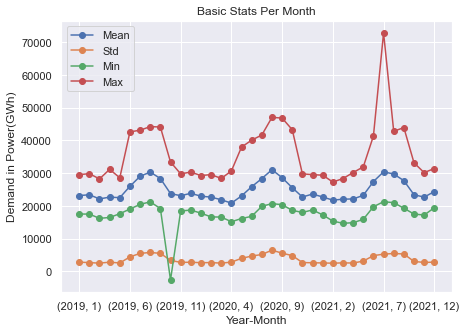

In [315]:
# calc mean, std, min, max per month
means = demands.groupby(by=[demands.index.year, demands.index.month]).mean()['Current demand']
stds = demands.groupby(by=[demands.index.year, demands.index.month]).std()['Current demand']
mins = demands.groupby(by=[demands.index.year, demands.index.month]).min()['Current demand']
maxs = demands.groupby(by=[demands.index.year, demands.index.month]).max()['Current demand']

basic_stats_year_month = pd.concat([means, stds, mins, maxs], axis=1, keys=['Mean', 'Std', 'Min', 'Max'])
basic_stats_year_month.plot(xlabel='Year-Month', ylabel='Demand in Power(GWh)', title='Basic Stats Per Month', marker='o')
pyplot.show()

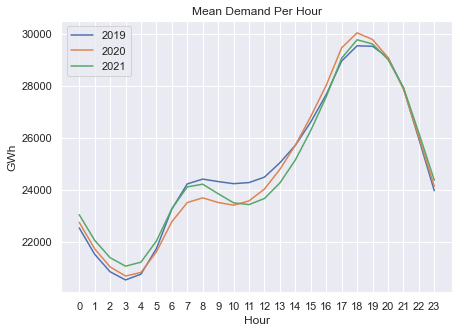

In [316]:
average_hour_per_year = demands.groupby(by=[demands.index.year, demands.index.hour]).mean()
pyplot.title('Mean Demand Per Hour')
pyplot.xlabel('Hour')
pyplot.ylabel('GWh')
pyplot.plot(average_hour_per_year[:24]['Current demand'].values, label='2019')
pyplot.plot(average_hour_per_year[24:48]['Current demand'].values, label='2020')
pyplot.plot(average_hour_per_year[48:]['Current demand'].values, label='2021')
pyplot.legend(loc='best')
pyplot.xticks(demands.index.hour.unique().values)
pyplot.show()

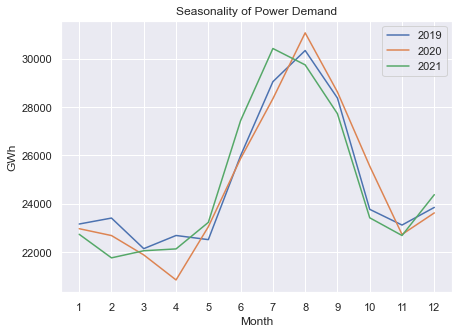

In [317]:
average_month_per_year = demands.groupby(by=[demands.index.year, demands.index.month]).mean()
pyplot.title('Seasonality of Power Demand')
pyplot.xlabel('Month')
pyplot.ylabel('GWh')
pyplot.plot(demands.index.month.unique().values, average_month_per_year[:12]['Current demand'].values, label='2019')
pyplot.plot(demands.index.month.unique().values, average_month_per_year[12:24]['Current demand'].values, label='2020')
pyplot.plot(demands.index.month.unique().values, average_month_per_year[24:]['Current demand'].values, label='2021')
pyplot.xticks(demands.index.month.unique().values)
pyplot.legend(loc='best')
pyplot.show()

In [318]:
"""
### check for stationarity
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(demands['Current demand'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(demands['Current demand'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
"""

"\n### check for stationarity\nfrom statsmodels.tsa.stattools import adfuller, kpss\n\n# ADF Test\nresult = adfuller(demands['Current demand'].values, autolag='AIC')\nprint(f'ADF Statistic: {result[0]}')\nprint(f'p-value: {result[1]}')\nfor key, value in result[4].items():\n    print('Critial Values:')\n    print(f'   {key}, {value}')\n\n# KPSS Test\nresult = kpss(demands['Current demand'].values, regression='c')\nprint('\nKPSS Statistic: %f' % result[0])\nprint('p-value: %f' % result[1])\nfor key, value in result[3].items():\n    print('Critial Values:')\n    print(f'   {key}, {value}')\n"

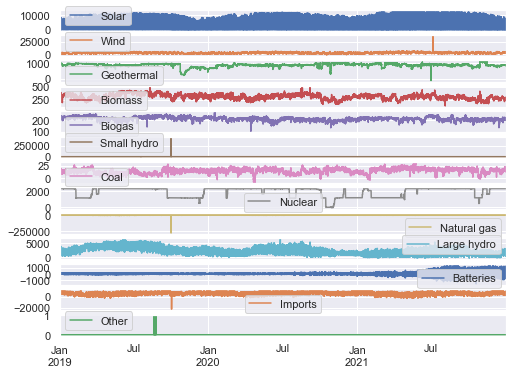

In [293]:
pyplot.rcParams['figure.figsize'] = [8, 6]
sources.plot(subplots=True)
pyplot.show()

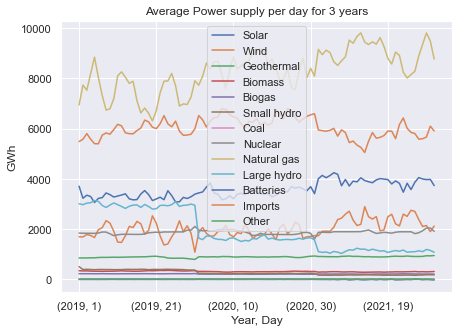

In [319]:
sources_day = sources.groupby(by=[sources.index.year, sources.index.day]).mean()
sources_day.plot(xlabel='Year, Day', ylabel='GWh', title='Average Power supply per day for 3 years')
pyplot.show()

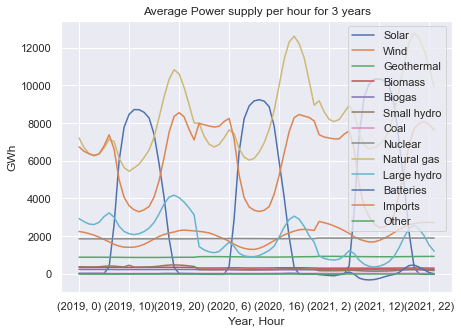

In [320]:
sources_hour = sources.groupby(by=[sources.index.year, sources.index.hour]).mean()
sources_hour.plot(xlabel='Year, Hour', ylabel='GWh', title='Average Power supply per hour for 3 years')
pyplot.show()

In [362]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.cluster import KMeans

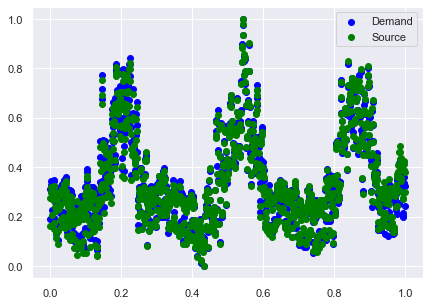

In [420]:
d_ts = pd.DataFrame(demands['Current demand'].groupby(by=[demands.index.year, demands.index.month, demands.index.day]).mean())
s_ts = pd.DataFrame(sources.sum(axis=1).groupby(by=[demands.index.year, demands.index.month, demands.index.day]).mean())

X_AXIS = [i for i in range(len(d_ts))]

# first plot data
demand_time_series = np.vstack((X_AXIS, d_ts.values.reshape(len(d_ts)))).T

# second plot data
sources_time_series = np.vstack((X_AXIS, s_ts.values.reshape(len(s_ts)))).T

# scale
demand_time_series_scaled = MinMaxScaler().fit_transform(demand_time_series)
sources_time_series_scaled = MinMaxScaler().fit_transform(sources_time_series)

# plot data 
pyplot.scatter(demand_time_series_scaled[:, 0], demand_time_series_scaled[:, 1], c='blue', label='Demand') 
pyplot.scatter(sources_time_series_scaled[:,0], sources_time_series_scaled[:,1], c='green', label='Source')
pyplot.legend()
pyplot.show()

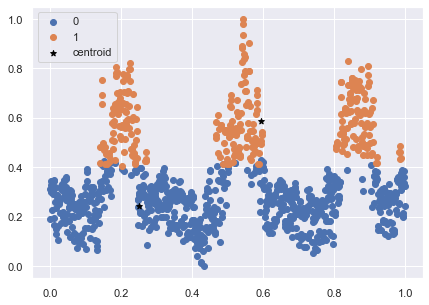

In [554]:
# demand_time_series_scaled, sources_time_series_scaled
X = demand_time_series_scaled[:, 0].copy()

cluster_data = np.vstack((demand_time_series_scaled[:, 1], sources_time_series_scaled[:, 1])).T

km = KMeans(n_clusters=2)
labels = km.fit_predict(cluster_data)

# Getting unique clusters
u_clusters = np.unique(labels)

for i in u_clusters:
    pyplot.scatter(X[labels == i], cluster_data[labels == i, i], label=i)

pyplot.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], color='black', marker='*', label='centroid')
pyplot.legend()
pyplot.show()

In [484]:
# normalize time series for clustering
time_series = [d_ts, s_ts]

for i in range(len(time_series)):
    scaler = MinMaxScaler()
    time_series[i] = MinMaxScaler().fit_transform(time_series[i])
    time_series[i]= time_series[i].reshape(len(time_series[i]))

X = np.vstack((time_series[0], time_series[1])).T

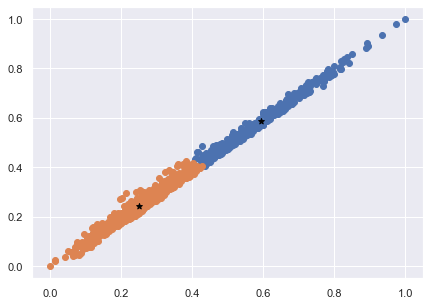

In [407]:
km = KMeans(n_clusters=2)

labels = km.fit_predict(X)

# Getting unique clusters
u_clusters = np.unique(labels)

# plotting the results:
for i in u_clusters:
    pyplot.scatter(X[labels == i, 0], X[labels == i, 1], label=i)

pyplot.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], color='black', marker='*', label='centroid')
pyplot.show()

In [408]:
import math
from tslearn.clustering import TimeSeriesKMeans

cluster_count = math.ceil(math.sqrt(len(time_series)))

# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

# km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

# labels = km.fit_predict(time_series)

ImportError: Numba needs NumPy 1.21 or less

In [238]:
sum_per_row = pd.DataFrame(sources.sum(axis=1))
avg_sum_per_row = sum_per_row.groupby(by=[sum_per_row.index.year, sum_per_row.index.month, sum_per_row.index.day]).mean()
y2 = avg_sum_per_row.iloc[:, 0].values

array([21948.07986111, 24086.52083333, 24920.34375   , ...,
       26928.46180556, 26110.63541667, 24576.61458333])

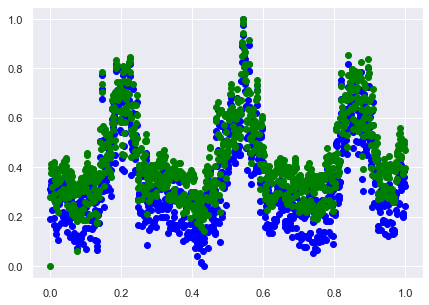

In [277]:
# prepare analysis
analysis = demands['Current demand'].groupby(by=[demands.index.year, demands.index.month, demands.index.day]).mean()

# first plot data
y1 = analysis.values
X = [i for i in range(len(analysis1))]
main_time_series = np.vstack((X, y1)).T

# second plot data
sum_per_row = pd.DataFrame(sources.sum(axis=1))
avg_sum_per_row = sum_per_row.groupby(by=[sum_per_row.index.year, sum_per_row.index.month, sum_per_row.index.day]).mean()
y2 = avg_sum_per_row.iloc[:, 0].values
sources_time_series = np.vstack((X, y2)).T

# scale
main_time_series_scaled = MinMaxScaler().fit_transform(main_time_series)
second_time_series_scaled = MinMaxScaler().fit_transform(sources_time_series)

# plot data 
pyplot.scatter(main_time_series_scaled[:, 0], main_time_series_scaled[:, 1], c='blue') 
pyplot.scatter(second_time_series_scaled[:,0], second_time_series_scaled[:,1], c='green')
pyplot.show()